Reference:
* [Notebook](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/ungradedLab/Wlfvj/implement-a-fully-convolutional-neural-network) in course "Advanced Computer Vision with TensorFlow" by DeepLearning.AI

* [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) TF official tutorial.

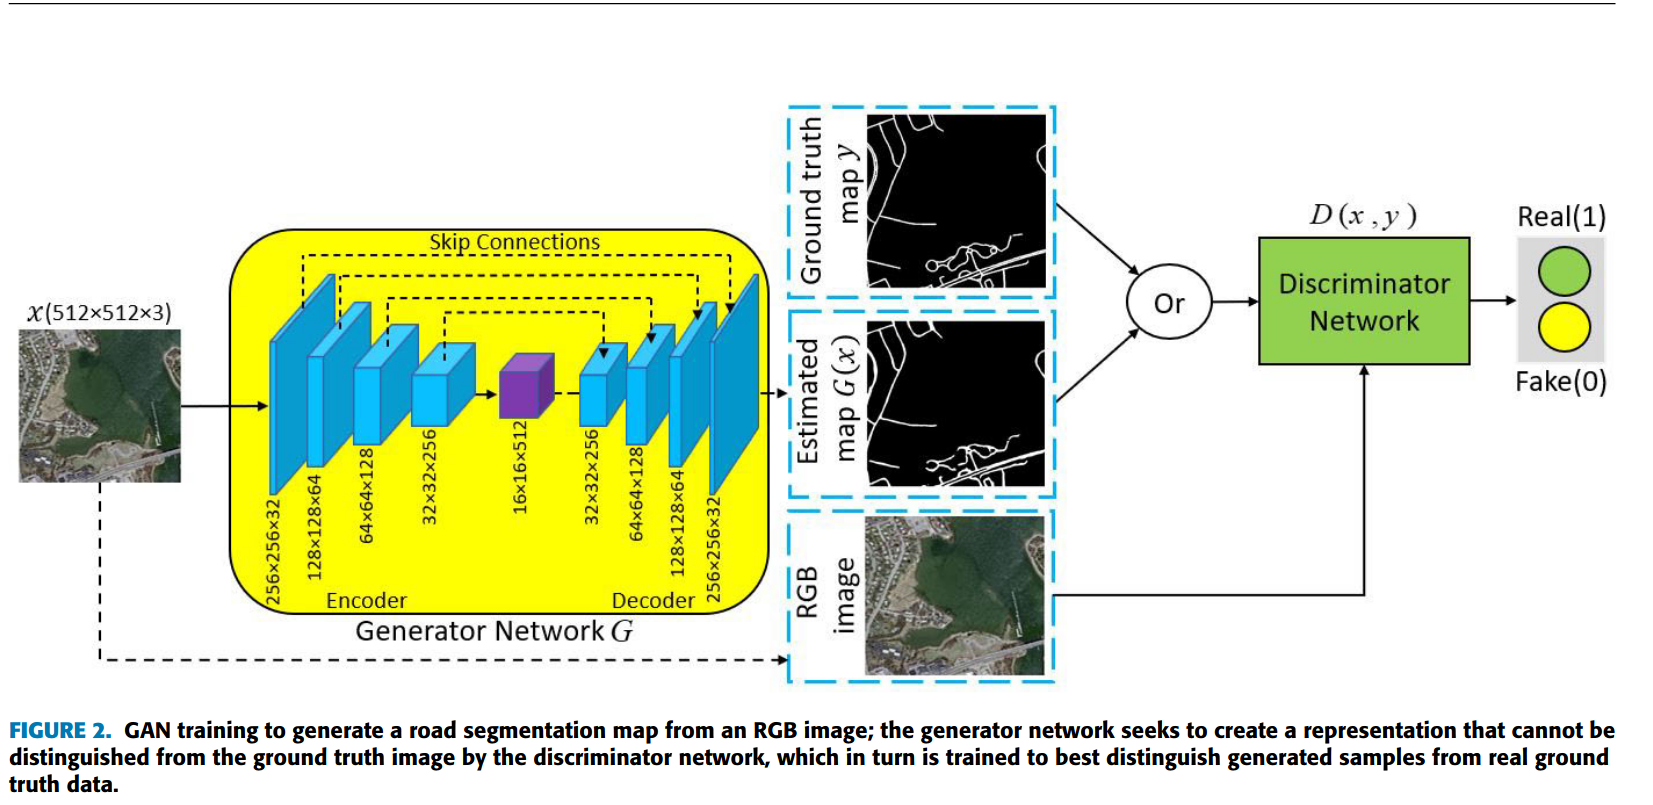

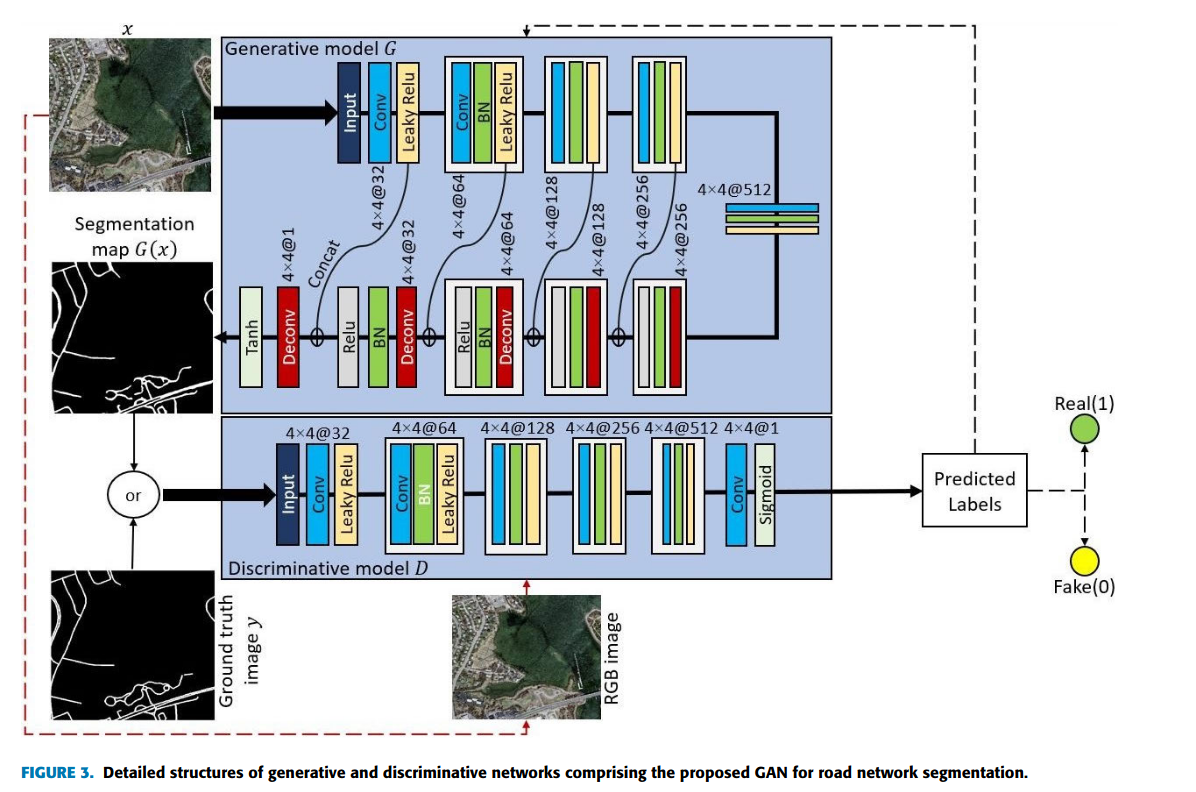

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

from glob import glob
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
BATCH_SIZE = 2

IMG_SIZE = 512

MASK_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

VERSION = '4.0'

# Generator

In [3]:
# https://github.com/bonlime/keras-deeplab-v3-plus

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')


In [4]:
generator = Deeplabv3(weights='cityscapes',
                 classes=NUM_CLASSES,
                 backbone='xception',
                 OS=16,
                 input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [5]:
# freeze Xception layers
for i, layer in enumerate(generator.layers):

    if i < 359:
        layer.trainable=False

In [6]:
generator.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

# Discriminator

## Utilities

In [7]:
def discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True):
    """
    Creates encoder block which consists of:
    
    Conv2d → BatchNormalization(except first block) → LeakyReLu
    
    Args:
        input_tensor (tensor) -- the input tensor
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size for the convolution
        batch_normalization -- if BatchNormalization layer should be
                               included
    Returns:
        x -- the output features of the discriminator block 
    """
    
    x = input_tensor
    
    x = layers.Conv2D(filters=n_filters, 
                      kernel_size=kernel_size,
                      strides=(2, 2),
                      activation='relu', 
                      padding='same',
                      name=block_name + '_Conv2D')(x)

    if batch_normalization:

        x = layers.BatchNormalization(name=block_name + '_BN')(x)

    x = layers.LeakyReLU(name=block_name + '_LeakyRelu')(x)
    
    return x

discriminator_block(input_tensor, n_filters, block_name,
                 kernel_size=4, batch_normalization=True)

In [8]:
def make_discriminator(input_shape = [512, 512, 5]):
    
    '''
    This function defines the discriminator.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    
    '''
    inputs = layers.Input(shape=input_shape)
    
    d1 = discriminator_block(inputs, 32, 'discriminator_block_1',
                            batch_normalization=False)
    
    d2 = discriminator_block(d1, 64, 'discriminator_block_2')
    
    d3 = discriminator_block(d2, 128, 'discriminator_block_3')
    
    d4 = discriminator_block(d3, 256, 'discriminator_block_4')
    
    d5 = discriminator_block(d4, 512, 'discriminator_block_5')
    
#     d6 = layers.Conv2D(filters=1, 
#                       kernel_size=4,
#                       strides=(2, 2),
#                       padding='same',
#                       name='discriminator_block_5_Conv2d')(d5)
    
#     d7 = layers.Activation(activation='sigmoid',
#                               name='discriminator_output')(d6)
    
    d8 = layers.Flatten()(d5)
    
    outputs = layers.Dense(1)(d8)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs,
                           name='Discriminator')
    
    return model

In [9]:

discriminator = make_discriminator()

discriminator.summary()
    

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 5)]     0         
_________________________________________________________________
discriminator_block_1_Conv2D (None, 256, 256, 32)      2592      
_________________________________________________________________
discriminator_block_1_LeakyR (None, 256, 256, 32)      0         
_________________________________________________________________
discriminator_block_2_Conv2D (None, 128, 128, 64)      32832     
_________________________________________________________________
discriminator_block_2_BN (Ba (None, 128, 128, 64)      256       
_________________________________________________________________
discriminator_block_2_LeakyR (None, 128, 128, 64)      0         
_________________________________________________________________
discriminator_block_3_Conv2D (None, 64, 64, 128)     

# Load data

In [10]:
abs_path = %pwd

In [11]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [12]:
DATA_DIR = abs_path + '/data/processed'

In [13]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

In [14]:
# def get_data_generator(path_to_data_split):
    
#     seed = 909
    
#     image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
#     mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    
#     image_generator = image_datagen.flow_from_directory(path_to_data_split+'/images',
#                                                        class_mode=None,
#                                                        batch_size=BATCH_SIZE,
#                                                        seed=seed,
#                                                        target_size=IMG_SIZE)

#     mask_generator = mask_datagen.flow_from_directory(path_to_data_split+'/masks',
#                                                      class_mode=None,
#                                                      batch_size=BATCH_SIZE,
#                                                      seed=seed,
#                                                      target_size=IMG_SIZE)
        
#     generator = zip(image_generator, mask_generator)

    
#     return generator 

In [15]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (MASK_SIZE, MASK_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[MASK_SIZE, MASK_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 255.
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def load_augmented_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = augmentation(image, mask)
    return image, mask


def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
    """
    Returns augmented or not augmented dataset with the same amount of elements.
    
    Args:
    image_list: list of paths to each image
    mask_list: list of paths to corresponding masks of images (sorted)
    augmentation: "True" for getting augmeneted images and masks
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    if augmentation:
        dataset = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    else:
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    if factor > 1 and augmentation:
        for _ in range(factor-1):
            dataset_to_concat = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
            dataset = dataset.concatenate(dataset_to_concat)

    return dataset

In [16]:
train_dataset = data_generator(train_images, train_masks, augmentation=False)
val_dataset = data_generator(val_images, val_masks)


print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))


Train Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7470
Val Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1602


In [17]:
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))
test_dataset = data_generator(test_images, test_masks)

print("Test Dataset:", test_dataset)

Test Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


## Images utilities

In [18]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [19]:
import matplotlib.pyplot as plt
import matplotlib

In [20]:
def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

In [21]:
def show_predictions():

    img, mask = zip(next(iter(test_dataset)))

    sample_img = img[0][0]
    sample_mask = mask[0][0]
    
    fig = plt.figure()

    f,ax = plt.subplots(1, 3, figsize=(12,6))
    
    ax[0].imshow(sample_img)
    ax[0].set_title('Real image')
    ax[0].axis('off')

    ax[1].imshow(sample_mask[:, :, 0])
    ax[1].set_title("Real mask")
    ax[1].axis('off')

    ax[2].imshow(create_mask(generator.predict(sample_img[tf.newaxis, ...])))
    ax[2].set_title("Generated mask")
    ax[2].axis('off')

<Figure size 432x288 with 0 Axes>

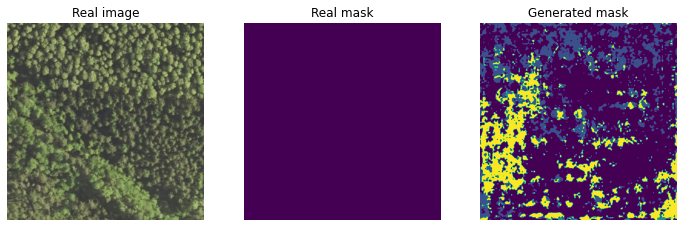

In [22]:
show_predictions()

# Loss and optimizers

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                              beta_1=0.9,
                                              beta_2=0.999)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999)

In [24]:
# y_true = [[0, 1.0, 0, 0, 0]]
# y_pred = [[0, 1,0.0, 0.0, 0.0]]
# # Using 'auto'/'sum_over_batch_size' reduction type.
# scce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# scce(y_true, y_pred).numpy()

In [25]:
# y_true = [[1.0]]
# y_pred = [[0.0]]
# # Using 'auto'/'sum_over_batch_size' reduction type.
# scce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# scce(y_true, y_pred).numpy()

In [26]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# wasserstein losses
# def _to_float(tensor):
#     return tf.cast(tensor, tf.float32)


# def wasserstein_generator_loss(
#     discriminator_gen_outputs,
#     weights=1.0,
#     scope=None,
#     loss_collection=tf.compat.v1.GraphKeys.LOSSES,
#     reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
#     add_summaries=False):
#     """Wasserstein generator loss for GANs.
#     See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
#     Args:
#     discriminator_gen_outputs: Discriminator output on generated data. Expected
#       to be in the range of (-inf, inf).
#     weights: Optional `Tensor` whose rank is either 0, or the same rank as
#       `discriminator_gen_outputs`, and must be broadcastable to
#       `discriminator_gen_outputs` (i.e., all dimensions must be either `1`, or
#       the same as the corresponding dimension).
#     scope: The scope for the operations performed in computing the loss.
#     loss_collection: collection to which this loss will be added.
#     reduction: A `tf.losses.Reduction` to apply to loss.
#     add_summaries: Whether or not to add detailed summaries for the loss.
#     Returns:
#     A loss Tensor. The shape depends on `reduction`.
#     """
#     with tf.compat.v1.name_scope(scope, 'generator_wasserstein_loss',
#                                (discriminator_gen_outputs, weights)) as scope:
        
#         discriminator_gen_outputs = _to_float(discriminator_gen_outputs)

#         loss = - discriminator_gen_outputs
#         loss = tf.compat.v1.losses.compute_weighted_loss(loss, weights, scope,
#                                                          loss_collection, reduction)

#         if add_summaries:
#             tf.compat.v1.summary.scalar('generator_wass_loss', loss)

#     return loss


# def wasserstein_discriminator_loss(
#     discriminator_real_outputs,
#     discriminator_gen_outputs,
#     real_weights=1.0,
#     generated_weights=1.0,
#     scope=None,
#     loss_collection=tf.compat.v1.GraphKeys.LOSSES,
#     reduction=tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS,
#     add_summaries=False):
    
#     """Wasserstein discriminator loss for GANs.
#     See `Wasserstein GAN` (https://arxiv.org/abs/1701.07875) for more details.
    
#     Args:
    
#     discriminator_real_outputs: Discriminator output on real data.
    
#     discriminator_gen_outputs: Discriminator output on generated data. Expected
#       to be in the range of (-inf, inf).
    
#     real_weights: Optional `Tensor` whose rank is either 0, or the same rank as
#       `discriminator_real_outputs`, and must be broadcastable to
#       `discriminator_real_outputs` (i.e., all dimensions must be either `1`, or
#       the same as the corresponding dimension).
    
#     generated_weights: Same as `real_weights`, but for
#       `discriminator_gen_outputs`.
    
#     scope: The scope for the operations performed in computing the loss.
    
#     loss_collection: collection to which this loss will be added.
    
#     reduction: A `tf.losses.Reduction` to apply to loss.
    
#     add_summaries: Whether or not to add summaries for the loss.
    
#     Returns:
#     A loss Tensor. The shape depends on `reduction`.
#     """
    
#     with tf.compat.v1.name_scope(
#         scope, 'discriminator_wasserstein_loss',
#         (discriminator_real_outputs, discriminator_gen_outputs, real_weights,
#         generated_weights)) as scope:

#         discriminator_real_outputs = _to_float(discriminator_real_outputs)
#         discriminator_gen_outputs = _to_float(discriminator_gen_outputs)
#         discriminator_real_outputs.shape.assert_is_compatible_with(
#             discriminator_gen_outputs.shape)

#         loss_on_generated = tf.compat.v1.losses.compute_weighted_loss(
#             discriminator_gen_outputs,
#             generated_weights,
#             scope,
#             loss_collection=None,
#             reduction=reduction)
#         loss_on_real = tf.compat.v1.losses.compute_weighted_loss(
#             discriminator_real_outputs,
#             real_weights,
#             scope,
#             loss_collection=None,
#             reduction=reduction)
#         loss = loss_on_generated - loss_on_real
#         tf.compat.v1.losses.add_loss(loss, loss_collection)

#         if add_summaries:
#             tf.compat.v1.summary.scalar('discriminator_gen_wass_loss',
#                                       loss_on_generated)
#             tf.compat.v1.summary.scalar('discriminator_real_wass_loss', loss_on_real)
#             tf.compat.v1.summary.scalar('discriminator_wass_loss', loss)

#     return loss


# generator_loss = wasserstein_generator_loss

# discriminator_loss = wasserstein_discriminator_loss

## Utilities for displaying images

In [28]:
def infer(model, image_tensor):
    predictions = model(np.expand_dims((image_tensor), axis=0), training=False)
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3), save_folder=None, epoch=None, image_num=None):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    
    if (save_folder != None) and (epoch != None) and (image_num != None):
        save_path = save_folder + 'epoch_{:04d}_#{}.png'.format(epoch+1, str(image_num))
        plt.savefig(save_path)
    
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model, save_folder=None, epoch=None):
    i=0
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], 
            figsize=(18, 14),
            save_folder=save_folder,
            epoch=epoch,
            image_num=i
        )
        i+=1


In [29]:
COLORMAP = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

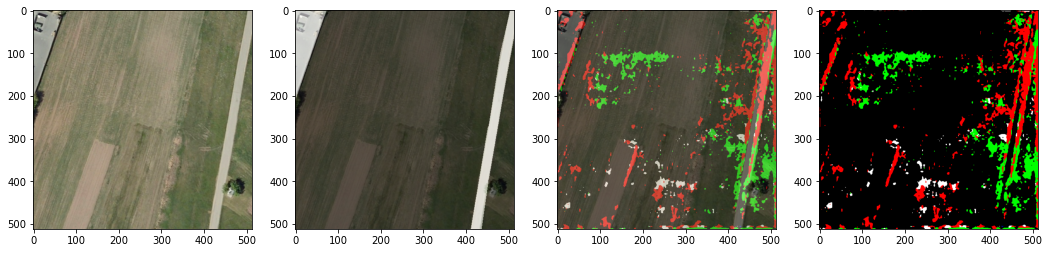

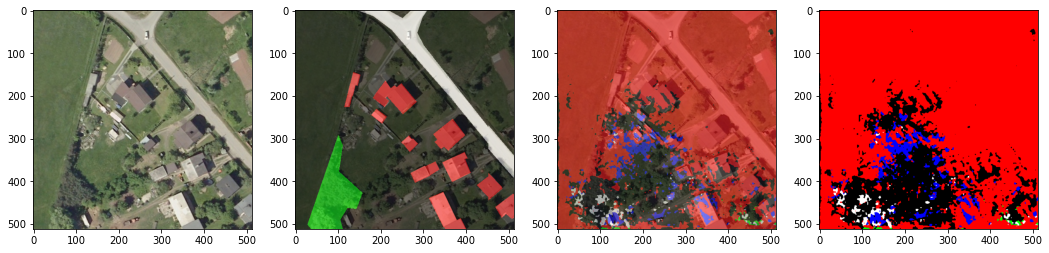

In [30]:
left_range = 448
right_range = 450

plot_predictions(test_images[left_range:right_range], test_masks[left_range:right_range] , COLORMAP, model=generator, save_folder=None)

## Metrics

In [31]:
def get_miou_for_images(images_list, masks_list, model):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

# Train GAN

In [32]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [33]:
EPOCHS = 50

In [34]:
checkpoint_dir = f'./results/GAN_MUnet/{VERSION}_version/every_4_epochs_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

pred_images_path = f'./results/GAN_MUnet/{VERSION}_version/images_predictions'

if not os.path.exists(pred_images_path):
    os.makedirs(pred_images_path)
    
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [35]:
def mask_to_categorical(mask):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), NUM_CLASSES)
    mask = tf.cast(mask, tf.float32)
    return mask

In [36]:
@tf.function
def train_step(tuple_images_masks_batch):
    
    images_batch, masks_batch = tuple_images_masks_batch
    
    masks_batch = mask_to_categorical(masks_batch)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_masks = generator(images_batch, training=True)

        real_output = discriminator(masks_batch, training=True)
        fake_output = discriminator(generated_masks, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
%matplotlib inline

In [38]:
def train(dataset, epochs):
    
    # calculates amount of steps
    i_when_end = 7470 // BATCH_SIZE
    
    # for storing miou score
    miou_data = []
    
    # training loop
    for epoch in range(epochs):
        start = time.time()
        
        i = 0
        
        for image_batch in dataset:
            
            if i > i_when_end:
                break
            
            train_step(image_batch)
            
            i += 1

        display.clear_output(wait=True)
        
        # for each epoch display predictions for 4 random validation images
        save_fig_folder = './results/GAN_MUnet/{}_version/images_predictions/'.format(VERSION)
        image_number = np.random.randint(0, NUM_TEST_IMAGES-5)
        plot_predictions(val_images[image_number: image_number+4],
                         val_masks[image_number: image_number+4],
                         colormap=COLORMAP,
                         save_folder=save_fig_folder,
                         epoch=epoch,
                         model=generator)
        
        # miou score
        miou = get_miou_for_images(val_images[:5], val_masks[:5], generator)
        
        miou_data.append(miou)
        
        # miou(epoch) plot
        save_plot_path = './results/GAN_MUnet/{}_version/miou_score.png'.format(VERSION)
        plt.figure()
        x = list(range(0, epoch+1))
        x = [int(y+1) for y in x]
        plt.xticks(x)
        plt.plot(x, miou_data)
        plt.show()
        plt.savefig(save_plot_path)
        plt.clf()
        
        print(f'val_mIoU = {miou}')

        # Save the model every 4 epochs
        if (epoch + 1) % 4 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [39]:
# # datasets for testing purposes
# train_dataset_testing = data_generator(train_images[:20], train_masks[:20], augmentation=False)
# val_dataset_testing = data_generator(val_images[:10], val_masks[:10])

# train(train_dataset_testing, EPOCHS)

<Figure size 432x288 with 0 Axes>

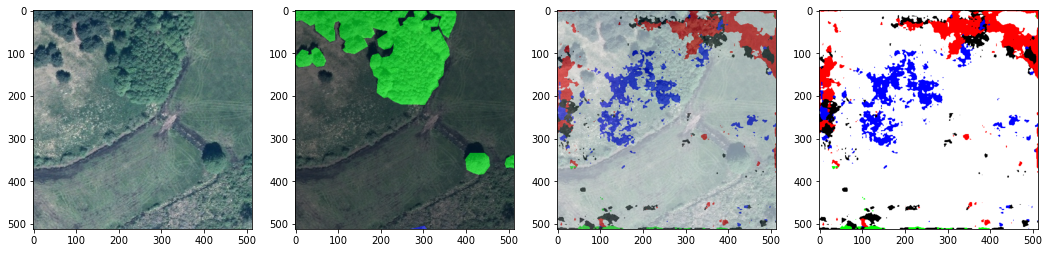

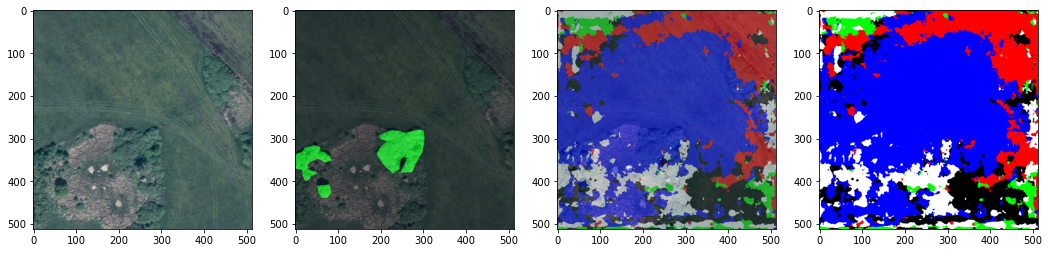

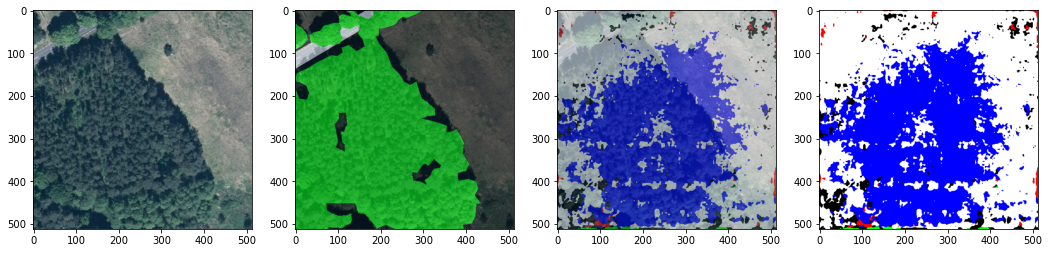

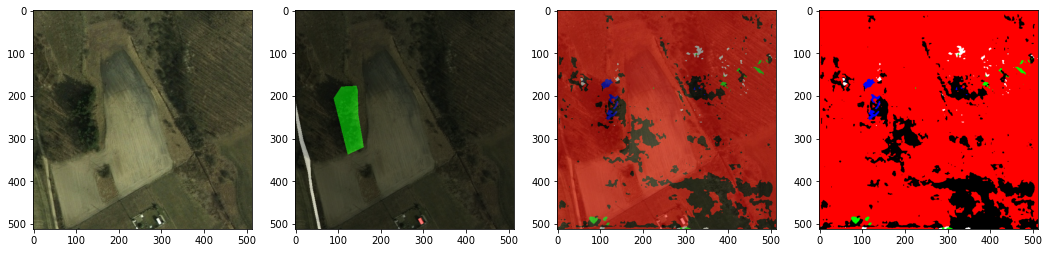

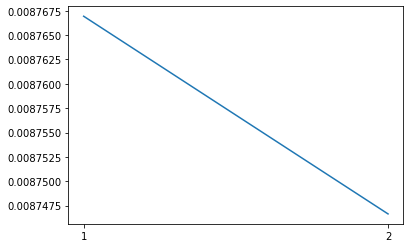

val_mIoU = 0.008746648207306862
Time for epoch 2 is 553.2454793453217 sec


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [40]:
train(train_dataset, EPOCHS)

In [ ]:
discriminator.save_weights(f'./results/GAN_DeepLabv3plus/{VERSION}_version/last_epoch/discriminator.h5')

In [ ]:
generator.save_weights(f'./results/GAN_DeepLabv3plus/{VERSION}_version/last_epoch/generator.h5')